## Figure 3c,d,e

In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring
from gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load the data
sets = ['training','leaderboard','testset']
descriptors = loading.get_descriptors(format='True')
all_CIDs = loading.get_CIDs(sets)
all_CID_dilutions = loading.get_CID_dilutions(sets)
#features = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
features = loading.get_molecular_data(['dragon','morgan'],all_CIDs)

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7306 total features.


In [3]:
# Create the feature and descriptor arrays 
X_rf,_,_,_,_,_ = dream.make_X(features,all_CID_dilutions)
X_lin = dream.quad_prep(features,all_CID_dilutions)
Y = loading.load_perceptual_data(sets)

The X matrix now has shape (814x5519) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x14614) molecules by non-NaN good molecular descriptors


### Load or compute the random forest model

In [4]:
# Load or compute the random forest model correlations (obtained from cross-validation)
use_saved_rf_model = True
n_splits = 100
n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
if use_saved_rf_model:
    rs0 = np.load('../../data/forest_rs_250_0.npy')
    rs0_9 = np.load('../../data/forest_rs_250_0-9.npy')
    rs10_20 = np.load('../../data/forest_rs_250_10-20.npy')
    rs_forest = rs0_9.copy()
    rs_forest[0,:,:] = rs0[0,:,:]
    rs_forest[10:,:,:] = rs10_20[10:,:,:]
    rs_forest = np.ma.array(rs_forest,mask=np.isnan(rs_forest))
else:
    trans_params = params.get_trans_params(Y_all, descriptors, plot=False)
    use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()
    rs_forest = fit2.feature_sweep(X_drag_morg[:,:-1],Y,n_estimators=50,n_splits=n_splits,n_features=n_features,model='rf',
                              rfe=False,max_features=max_features,max_depth=max_depth,min_samples_leaf=min_samples_leaf)
    np.save('../../data/rs_forest_%d',rs_forest)

### Load or compute the linear model

In [5]:
# Load or compute the feature ranks for the training set
use_saved_linear_feature_ranks = True
if use_saved_linear_feature_ranks:
    lin_ranked = np.load('../../data/lin_ranked_rick.npy')
else:
    # -1 is to leave out the leak feature
    lin_ranked = fit1.compute_linear_feature_ranks_cv(X_train_lin[:,:-1],Y_all['mean_std'],
                                                      n_resampling=10,n_splits=n_splits)
    np.save('../../data/lin_ranked_rick',lin_ranked)

In [6]:
use_saved_lin_model = True
if use_saved_lin_model:
    rs_lin = np.load('../../data/rs_lin_rick_right.npy')
    rs_lin = np.ma.array(rs_lin,mask=np.isnan(rs_lin))
else:
    rs_lin = feature_sweep(X_drag_morg_sq[:,:-1],Y,n_splits=n_splits,model='lin',rfe=False,
                           alpha=10.0,lin_ranked=lin_ranked)
    np.save('../../data/rs_forest_%d',rs_forest)

## Figure 3c

In [7]:
from scipy.interpolate import interp1d

# Plotting function
def plot(forest,lin,labels=['forest','quadratic'],threshold=0.8):
    fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
    thresholds, thresh_locs = np.zeros(21), np.zeros(21)
    n_features2 = np.logspace(0,4,1000)
    for col in range(21):
        curve = forest[col,:,:].mean(axis=1)
        f = interp1d(n_features,curve)
        curve = f(n_features2)
        thresholds[col] = max(curve[0],threshold*curve.max())
        thresh_index = np.where(curve>thresholds[col])[0][0]
        #print(col,thresh_index,len(n_features2),n_features2[thresh_index])
        thresh_locs[col] = n_features2[thresh_index]
    ranks = np.argsort(thresh_locs)
    forest[col,:,:].mean(axis=1)
    for rank,ax in enumerate(axes.flat):
        col = ranks[rank]
        ax.errorbar(n_features,forest[col,:,:].mean(axis=1),forest[col,:,:].std(axis=1)/np.sqrt(n_splits),color='red',label=labels[0])
        ax.errorbar(n_features,lin[col,:,:].mean(axis=1),lin[col,:,:].std(axis=1)/np.sqrt(n_splits),color='black',label=labels[1])
        if col==0:
            handles, labels = ax.get_legend_handles_labels()
            lg = ax.legend(handles[0:], labels[0:], loc=4, fontsize=16)
            lg.draw_frame(False)
        ax.set_xlim(0.5,20000)
        ax.set_ylim(0,0.8)
        ax.set_yticks(np.linspace(0,0.6,4))
        ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
        ax.set_xticklabels(n_features,size=20)
        ax.set_xscale('log')
        ax.set_title(descriptors[col], size=25)
        ax.plot([0,thresh_locs[col]],[thresholds[col],thresholds[col]],'b--')
        ax.plot([thresh_locs[col],thresh_locs[col]],[0,thresholds[col]],'b--')
        #break
        print('%s: %.1f' % (descriptors[col],thresh_locs[col]))#,thresholds[col])
    fig.text(0.5, 1.00, 'Threshold = %d%%' % (threshold*100), ha='center', size=25)
    fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
    fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);
    plt.tight_layout()

Fish: 1.0
Warm: 1.7
Garlic: 2.5
Bakery: 3.1
Chemical: 4.0
Fruit: 4.3
Spices: 4.9
Sweet: 5.8
Wood: 5.9
Pleasantness: 6.0
Grass: 6.6
Sour: 6.9
Decayed: 7.8
Acid: 8.0
Cold: 8.0
Musky: 8.3
Ammonia: 9.4
Sweaty: 11.0
Flower: 14.2
Burnt: 15.0
Intensity: 15.7


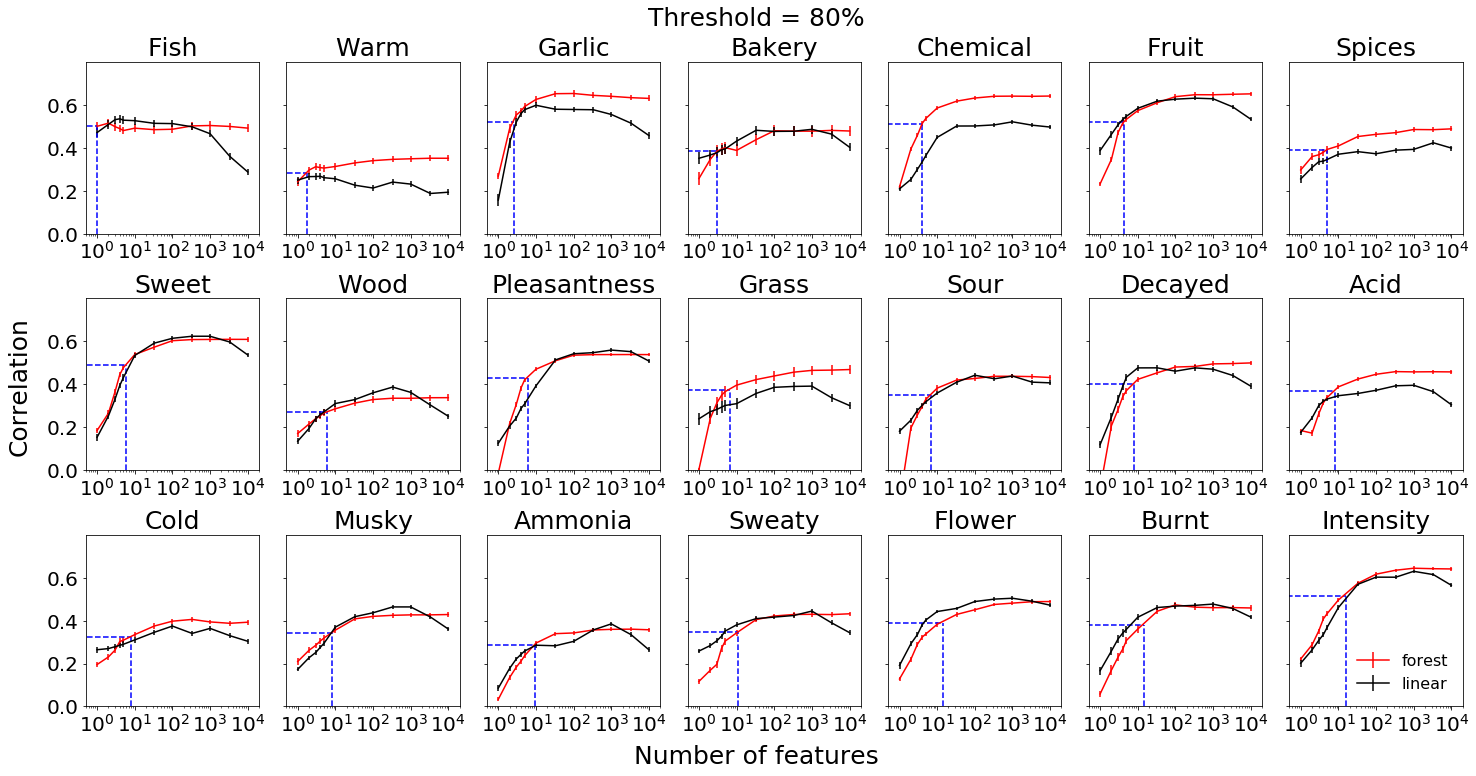

In [8]:
plot(rs_forest[:,:,:n_splits],rs_lin[:,:,:n_splits],labels=['forest','linear'],threshold=0.8)
plt.savefig('../../figures/forest_vs_features_%d.eps' % (0.8*100),format='eps',bbox_inches='tight',pad_inches=0.5)